# Run additional tests on Sicorello et al. preprint data
- [Preprint](https://www.medrxiv.org/content/10.1101/2021.02.03.21251077v1.full-text)
- [Dataset](https://github.com/MaurizioSicorello/MVPAemoDys_Analyses)


In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.stats import threshold
from nltools.mask import expand_mask
from pymer4.models import Lm, Lmer


base_dir = '/Users/lukechang/Github/MVPAemoDys_Analyses/'

In [98]:
data = pd.read_csv(os.path.join(base_dir, 'Data', 'Preprocessed_Data', 'EmoPattern_neuralData.csv'))
data['NegVNeu_Pines'] = data['NegPines'] - data['NeutPines']

data.head()

,ID,NegPines,NeutPines,NegViewAmyR,NeutViewAmyR,NegViewAmyStriatR,NeutViewAmyStriatR,NegViewAmyL,NeutViewAmyL,NegViewAmyHippL,...,NegViewKragelSad,NeutViewKragelSad,NegViewKragelSurprised,NeutViewKragelSurprised,study,run,rundescr,group,med_bin,NegVNeu_Pines
0,1,3.699178,2.298523,0.185534,-0.617607,-0.154609,-0.391623,-0.284434,-0.765143,0.057052,...,0.219886,1.207439,10.391170,5.705316,ewmt,1,only_run,PTSD,1,1.400655
1,2,6.529484,3.837654,3.709618,2.956326,1.804343,1.246959,3.165085,2.016855,2.214303,...,-1.463477,-0.546377,13.075072,11.599843,ewmt,1,only_run,PTSD,0,2.691830
2,3,4.680291,1.502163,1.208177,-1.513596,0.979599,-0.179145,0.915030,-2.031368,0.823471,...,-3.327803,-2.255531,9.952443,9.931742,ewmt,1,only_run,PTSD,1,3.178128
3,4,-1.457909,-1.611831,-2.123461,-1.943405,-2.429051,-1.314551,-1.497567,-2.182068,-0.969083,...,-4.887822,-5.549086,8.502635,4.521690,ewmt,1,only_run,PTSD,1,0.153922
4,5,7.201664,7.424095,2.638709,2.655824,2.774511,3.687431,6.163799,7.236422,5.177392,...,-3.346959,-3.132273,8.702096,5.398829,ewmt,1,only_run,PTSD,0,-0.222431


# Forced Choice Accuracy
Accuracy in Chang et al., 2015 used *Forced Choice* Accuracy, which controls for within subject variation. A quick check indicates very comparable performance in discriminating between negative vs neutral in Sicorello Dataset.

In [100]:
data['NegVNeu_FC'] = data['NegPines'] > data['NeutPines']

data.groupby(['study','group','run']).mean()['NegVNeu_FC']

study   group     run
emoreg  BPD       1      1.000000
                  2      1.000000
                  3      1.000000
        HC        1      1.000000
                  2      1.000000
                  3      0.964286
ewmt    HC        1      0.878788
        PTSD      1      0.870968
        TC        1      0.933333
react   BPDacute  1      0.950000
                  2      0.900000
                  3      1.000000
        BPDremit  1      1.000000
                  2      0.920000
                  3      1.000000
        HC        1      1.000000
                  2      0.950000
                  3      1.000000
Name: NegVNeu_FC, dtype: float64

## Let's collapse runs within group and study

study   group   
emoreg  BPD         1.000000
        HC          0.988095
ewmt    HC          0.878788
        PTSD        0.870968
        TC          0.933333
react   BPDacute    0.950000
        BPDremit    0.974026
        HC          0.983333
Name: NegVNeu_FC, dtype: float64


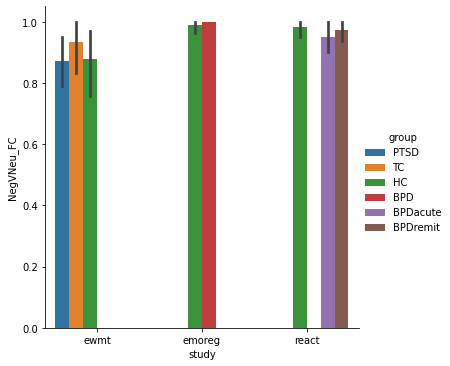

In [101]:
data_run_avg = []
for study in data['study'].unique():
    for group in data.query('study==@study')['group'].unique():
        tmp = data.query('study==@study & group==@group').groupby('ID').mean()
        tmp['study'] = study
        tmp['group'] = group
        data_run_avg.append(tmp)
data_run_avg = pd.concat(data_run_avg, axis=0)
data_run_avg['ID'] = data_run_avg.index

print(data.groupby(['study','group']).mean()['NegVNeu_FC'])

sns.catplot(data=data_run_avg, x='study', y='NegVNeu_FC', hue='group', kind='bar')

# Disorder Specific Discrepancy between Predicted and Observed Ratings?
Not sure if Sicorello et al, collected subjective ratings for each trial, but one interesting analysis they could try is assessing if there is a discrepancy between the PINES model in predicting ratings as a function of clinical group or status.

This idea is equivalent to the *Moderation by demographic variables* analysis from Chang et al., 2015.

Single trial data or rating average data were not available in the Sicorello Github repository for me to test, but might be interesting to explore in future.

# Pattern Similarity vs Pattern Expression
Sicorello et al., used the dot product, which we tend to refer to as *pattern expression*. However, due to baseline differences this approach can be noisy when applied to new datasets. We often use normalized or standardized pattern similarity by using spatial pearson or spearman rho correlations rather than dot-product.

This could be interesting to see if it impacts results if Sicorello et al., share their imaging data so that we could run different first level models.

# Look at Negative vs Neutral comparisons between groups across studies
It looks like there is a significant difference between groups in "react" study

In [102]:
data_run_avg_long = data_run_avg.melt(id_vars=['ID', 'study', 'group','med_bin'], value_vars=['NegVNeu_Pines', 'NegVNeu_FC', 'NegPines', 'NeutPines'])
data_long = data.melt(id_vars=['ID', 'study', 'group','med_bin','run'], value_vars=['NegVNeu_Pines', 'NegVNeu_FC', 'NegPines', 'NeutPines'])

print(data_run_avg_long['study'].unique())

data_run_avg_long.head()


['ewmt' 'emoreg' 'react']


,ID,study,group,med_bin,variable,value
0,1,ewmt,PTSD,1,NegVNeu_Pines,1.400655
1,2,ewmt,PTSD,0,NegVNeu_Pines,2.691830
2,3,ewmt,PTSD,1,NegVNeu_Pines,3.178128
3,4,ewmt,PTSD,1,NegVNeu_Pines,0.153922
4,5,ewmt,PTSD,0,NegVNeu_Pines,-0.222431


In [103]:

for study in data_run_avg_long['study'].unique():
    print(f"\nSTUDY: {study}")
    model = Lm("value ~ group", data=data_run_avg_long.query('variable=="NegVNeu_Pines"&study==@study'))

    print(model.fit())


STUDY: ewmt
Formula: value~group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 125	 R^2: 0.010	 R^2_adj: -0.006

Log-likelihood: -227.098 	 AIC: 460.196	 BIC: 468.681

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE   DF  T-stat  P-val  Sig
Intercept         1.766   1.247    2.285  0.262  122   6.733  0.000  ***
group[T.PTSD]     0.255  -0.388    0.898  0.325  122   0.786  0.434     
group[T.TC]      -0.084  -0.836    0.669  0.380  122  -0.221  0.826     

STUDY: emoreg
Formula: value~group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 57	 R^2: 0.002	 R^2_adj: -0.016

Log-likelihood: 42.957 	 AIC: -81.914	 BIC: -77.828

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept       0.439   0.396    0.482  0.022  55  20.400  0.000  ***
group[T.HC]     0.011  -0.051    0.072  0.0

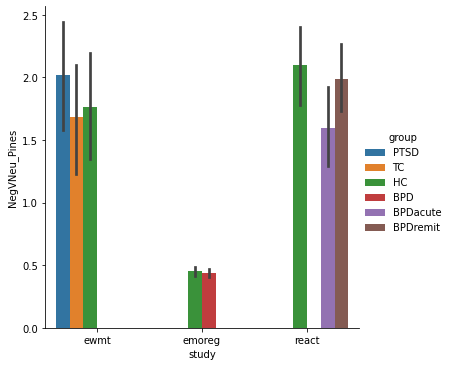

In [11]:
sns.catplot(data=data, x='study', y='NegVNeu_Pines', hue='group', kind='bar')

## Look at same comparison only with non-medicated participants

In [104]:
for study in data_run_avg_long['study'].unique():
    print(f"\nSTUDY: {study}")
    model = Lm("value ~ group", data=data_run_avg_long.query('variable=="NegVNeu_Pines"&study==@study&med_bin=="0"'))

    print(model.fit())


STUDY: ewmt
Formula: value~group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 91	 R^2: 0.001	 R^2_adj: -0.021

Log-likelihood: -153.357 	 AIC: 312.713	 BIC: 320.246

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept         1.766   1.307    2.225  0.231  88   7.644  0.000  ***
group[T.PTSD]    -0.112  -0.790    0.565  0.341  88  -0.329  0.743     
group[T.TC]      -0.084  -0.749    0.581  0.335  88  -0.251  0.803     

STUDY: emoreg
Formula: value~group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 53	 R^2: 0.002	 R^2_adj: -0.018

Log-likelihood: 38.532 	 AIC: -73.064	 BIC: -69.124

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept       0.441   0.393    0.488  0.024  51  18.477  0.000  ***
group[T.HC]     0.010  -0.056    0.075  0.033  5

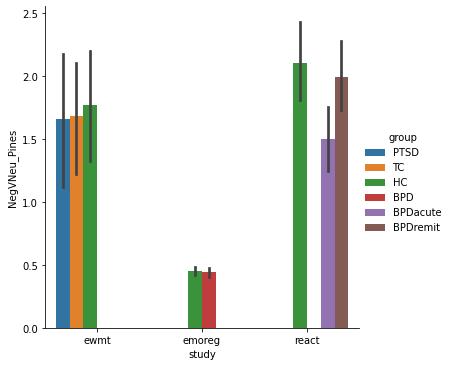

In [105]:
sns.catplot(data=data.query('med_bin==0'), x='study', y='NegVNeu_Pines', hue='group', kind='bar')